In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold

from PIL import Image

torch.manual_seed(0)
np.random.seed(0)


In [85]:
# # test
# !pip freeze

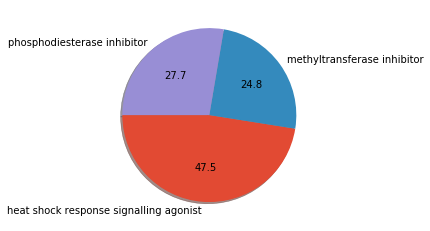

<Figure size 2304x2304 with 0 Axes>

In [6]:

specs_df = pd.read_csv("/home/jovyan/scratch-shared/xiaobo/Labels.csv")
# df.head()

# selected_mechanism_11 = ['heat shock response signalling agonist', 'methyltransferase inhibitor', 'phosphodiesterase inhibitor', 'DILI', 'negcon_PHB000001',
#                          'HDAC inhibitor', 'topoisomerase inhibitor', 'mTOR inhibitor', 'NFkB pathway inhibitor', 'JAK inhibitor', 'pregnane x receptor agonist']
# specs_sm11_df = specs_df[specs_df['selected_mechanism'].isin(selected_mechanism_11)]
# specs_sm11_df = specs_sm11_df[['ImageNr', 'selected_mechanism']]
# sm_dict = {
#            'heat shock response signalling agonist' : 0, 'methyltransferase inhibitor' : 1, 'phosphodiesterase inhibitor' : 2,
#            'DILI' : 3,                                   'HDAC inhibitor' : 4,              'topoisomerase inhibitor' : 5,
#            'mTOR inhibitor' : 6,                         'NFkB pathway inhibitor' : 7,      'JAK inhibitor' : 8,
#            'pregnane x receptor agonist' : 9 ,           'negcon_PHB000001' : 10
#           }

# base_dir = '/home/jovyan/Specs0314-jpeg-q100-11sm/'

selected_mechanism_3 = ['heat shock response signalling agonist', 'methyltransferase inhibitor', 'phosphodiesterase inhibitor']
specs_sm3_df = specs_df[specs_df['selected_mechanism'].isin(selected_mechanism_3)]
specs_sm3_df = specs_sm3_df[['ImageNr', 'selected_mechanism']]
sm_dict = {'heat shock response signalling agonist' : 0, 'methyltransferase inhibitor' : 1, 'phosphodiesterase inhibitor' : 2}

base_dir = '/home/jovyan/Specs0314-png-8bit-3sm-hific-medium-image/'
# base_dir = '/home/jovyan/Specs0314-jpeg-q100-3sm/'

df_len = len(specs_sm3_df)
lst = []
# col = ('id' + df.iloc[0].index[0]).split(';')

for i in range(df_len):
    a = specs_sm3_df.iloc[i].values
    # v = a.values[0].split(';')

    # a[0] = str(a[0]) + '.png'
    a[0] = str(a[0]) + '_hific-mi.png'
    # a[0] = str(a[0]) + '.jpg'
    a[1] = sm_dict[a[1]]
    lst.append(a)


data_df = pd.DataFrame(lst, columns=['ImagePath', 'selected_mechanism'])

labels_count = specs_sm3_df.selected_mechanism.value_counts().sort_index()

%matplotlib inline
# labels_name = ['heat shock response signalling agonist', 'methyltransferase inhibitor', 'phosphodiesterase inhibitor', 
#                'DILI', 'HDAC inhibitor', 'topoisomerase inhibitor', 'mTOR inhibitor', 'NFkB pathway inhibitor', 
#                'JAK inhibitor', 'pregnane x receptor agonist', 'negcon_PHB000001']
labels_name = ['heat shock response signalling agonist', 'methyltransferase inhibitor', 'phosphodiesterase inhibitor']

plt.pie(labels_count, labels=labels_name,
        startangle=180, 
        autopct='%1.1f',
#         colors=['#00ff99','#FF96A7'],
        shadow=True)
plt.figure(figsize=(32,32))
plt.show()

# # print("Train Size: {}".format(len(train_df)))
# # print("Validation Size: {}".format(len(val_df)))
# # print("Test Size: {}".format(len(test_df)))

# # train_df

In [7]:
# test
# specs_sm11_df.iloc[0].values[0]
data_df.head()
# specs_sm11_df.head()
# specs_sm3_df
# specs_sm3_df.iloc[0].values

,ImagePath,selected_mechanism
0,46881_hific-mi.png,2
1,46883_hific-mi.png,2
2,46882_hific-mi.png,2
3,46886_hific-mi.png,2
4,46887_hific-mi.png,2


In [8]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, data_df, data_dir=base_dir, transform=None):
        super().__init__()
        self.df = data_df.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
#         img_name,label = self.df[index]
        img_name, label = self.df[index]

#         target = torch.zeros(nb_classes)
#         target[label] = 1
        
#         img_path = os.path.join(self.data_dir, img_name+'.tif')
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
batch_size = 8

transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
#     MydctTransform(coeff_num=6),
#     MyidctTransform(coeff_num=6),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
#     MydctTransform(coeff_num=6),
#     MyidctTransform(coeff_num=6),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


epoch:  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


100
104.8522617816925
300
318.2317771911621
400
423.3659358024597
500
529.2877771854401
600
633.7978675365448
Epoch: 1 | Training Loss: 0.554837 | Train ACC: 0.7573
epoch:  2
100
807.8478062152863
200
897.5843458175659
300
986.4471862316132
400
1076.423518896103
500
1166.5920150279999
600
1256.0132749080658
Epoch: 2 | Training Loss: 0.393570 | Train ACC: 0.8432
epoch:  3
100
1415.2703533172607
200
1504.100724697113
300
1593.5226230621338
400
1682.8624005317688
500
1771.4717535972595
600
1859.1850481033325
Epoch: 3 | Training Loss: 0.311586 | Train ACC: 0.8756
epoch:  4
100
2017.8675470352173
200
2106.3559427261353
300
2194.1921331882477
400
2282.7087676525116
500
2371.9592587947845
600
2461.7316977977753
Epoch: 4 | Training Loss: 0.258973 | Train ACC: 0.8979
epoch:  5
100
2619.795650243759
200
2707.8527088165283
300
2795.6013011932373
400
2883.7002880573273
500
2971.712427377701
600
3058.3798081874847
Epoch: 5 | Training Loss: 0.229436 | Train ACC: 0.9104
epoch:  6
100
3215.47036004066

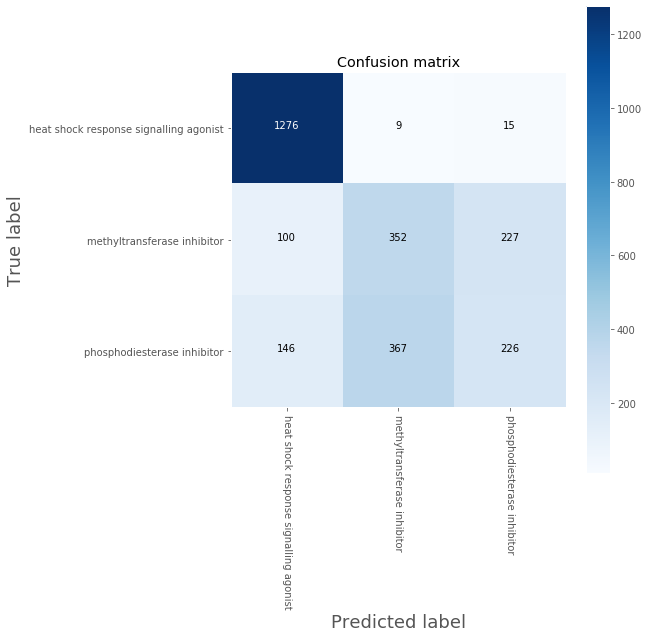

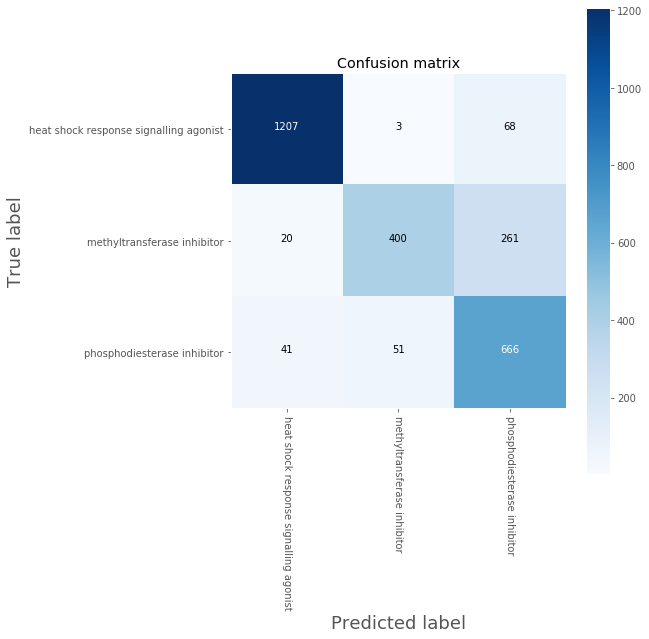

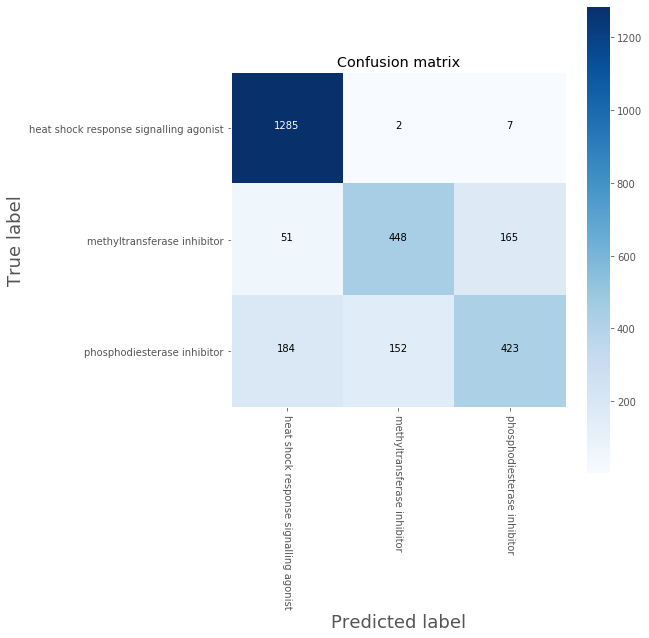

In [11]:

k_folds = 3
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)

# keeping track of losses as it happen
val_losses = []
val_accuracies = []

kfold_preds = []
kfold_targets = []

for train, val in kfold.split(data_df):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # model = models.inception_v3(pretrained=True)
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to len(labels_name).
    model.fc = nn.Linear(num_ftrs, len(labels_name))
    model = model.to(device)

    # initial_model = copy.deepcopy(model)
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    #     print('Resetting model')
    #     model = inital_model
    

    train_df = data_df.iloc[train].sample(frac=1, random_state=0)
    val_df = data_df.iloc[val].sample(frac=1, random_state=0)


    train_data = CreateDataset(data_df=train_df, data_dir=base_dir, transform=transforms_train)
    val_data = CreateDataset(data_df=val_df, data_dir=base_dir, transform=transforms_test)
    train_loader = DataLoader(train_data, batch_size=batch_size)
    valid_loader = DataLoader(val_data, batch_size=batch_size)
    
    # number of epochs to train the model
    n_epochs = 20
    val_loss_min = np.Inf
    since = time.time()

    for epoch in range(1, n_epochs+1):       
        print('epoch: ', epoch)
        with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
            f.write('epoch: ' + repr(epoch) + "\n")

        # keep track of training and validation loss
        train_loss = 0.0
        val_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        train_correct = 0
        train_total = 0
        
        i  = 0
        for data, target in train_loader:
            i += 1
            if i % 100 == 0:
                print(i)
                print(time.time() - since)
                with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
                    f.write(repr(i) + "\n")
                    f.write(repr(time.time() - since) + "\n")
                    
                
            # print(data)
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda().long()
    #         target = target.view(-1, 1)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
    #         print(output)
            # print('t', target)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # Update Train loss and accuracies
            train_loss += loss.item()*data.size(0)

            _, y_pred = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (y_pred == target).sum().item()

        train_acc = train_correct / train_total
        train_loss = train_loss/len(train_loader.sampler)
        
        # print training statistics 
        print('Epoch: {} | Training Loss: {:.6f} | Train ACC: {:.4f}'.format(epoch, train_loss, train_acc))
        with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
            f.write('Epoch: {} | Training Loss: {:.6f} | Train ACC: {:.4f}'.format(epoch, train_loss, train_acc)+"\n")
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
        f.write('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)+"\n")

    ######################    
    # validate the model #
    ######################
    model.eval()
    val_correct = 0
    val_total = 0
    val_preds = []
    val_targets = []
    
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().long()
        # forward pass: compute predicted outputs by passing inputs to the model
#         target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        val_loss += loss.item()*data.size(0)
        #output = output.topk()
#         y_actual = target.data.cpu().numpy()
        _, y_pred = torch.max(output, 1)
        val_total += target.size(0)
        val_correct += (y_pred == target).sum().item()
        
        val_preds += y_pred.tolist()
        val_targets += target.tolist()


    ##############################################################################

    val_acc = val_correct / val_total
    # calculate average losses
    val_loss = val_loss/len(valid_loader.sampler)

    val_accuracies.append(val_acc)    
    val_losses.append(val_loss)

    kfold_preds.append(val_preds)
    kfold_targets.append(val_targets)

    # print training/validation statistics 
    print('Validation Loss: {:.6f} | Validation ACC: {:.4f}'.format(val_loss, val_acc))
    with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
        f.write('Validation Loss: {:.6f} | Validation ACC: {:.4f}'.format(val_loss, val_acc)+"\n")

    # # save model
    # if val_loss <= val_loss_min:
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
    #     torch.save(model.state_dict(), 'best_model.pt')
    #     val_loss_min = val_loss



cm0 = confusion_matrix(kfold_targets[0], kfold_preds[0])
print("kfold preds 0: ", kfold_preds[0])
print("kfold targets 0: ", kfold_targets[0])
print(accuracy_score(kfold_targets[0], kfold_preds[0]))
print(cm0)
with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
    f.write('kfold preds 0: ' + repr(kfold_preds[0]) + '\n')
    f.write('kfold targets 0: ' + repr(kfold_targets[0]) + '\n')
    f.write(repr(accuracy_score(kfold_targets[0], kfold_preds[0]))+"\n")
    f.write(repr(cm0)+"\n")

cm1 = confusion_matrix(kfold_targets[1], kfold_preds[1])
print("kfold preds 1: ", kfold_preds[1])
print("kfold targets 1: ", kfold_targets[1])
print(accuracy_score(kfold_targets[1], kfold_preds[1]))
print(cm1)
with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
    f.write('kfold preds 1: ' + repr(kfold_preds[1]) + '\n')
    f.write('kfold targets 1: ' + repr(kfold_targets[1]) + '\n')
    f.write(repr(accuracy_score(kfold_targets[1], kfold_preds[1]))+"\n")
    f.write(repr(cm1)+"\n")

cm2 = confusion_matrix(kfold_targets[2], kfold_preds[2])
print("kfold preds 2: ", kfold_preds[2])
print("kfold targets 2: ", kfold_targets[2])
print(accuracy_score(kfold_targets[2], kfold_preds[2]))
print(cm2)
with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
    f.write('kfold preds 2: ' + repr(kfold_preds[2]) + '\n')
    f.write('kfold targets 2: ' + repr(kfold_targets[2]) + '\n')
    f.write(repr(accuracy_score(kfold_targets[2], kfold_preds[2]))+"\n")
    f.write(repr(cm2)+"\n")

# cm3 = confusion_matrix(kfold_targets[3], kfold_preds[3])
# print("kfold preds 3: ", kfold_preds[3])
# print("kfold targets 3: ", kfold_targets[3])
# print(accuracy_score(kfold_targets[3], kfold_preds[3]))
# print(cm3)

# cm4 = confusion_matrix(kfold_targets[4], kfold_preds[4])
# print("kfold preds 4: ", kfold_preds[4])
# print("kfold targets 4: ", kfold_targets[4])
# print(accuracy_score(kfold_targets[4], kfold_preds[4]))
# print(cm4)


import itertools

def plot_confusion_matrix(cm, classes, savefig_name, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(pad=5)
    plt.grid(b=None)
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.savefig(savefig_name)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm0, labels_name, 'CM0-png-8bit-hific-mi-3sm-e20.pdf',  normalize=False)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm1, labels_name, 'CM1-png-8bit-hific-mi-3sm-e20.pdf',  normalize=False)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm2, labels_name, 'CM2-png-8bit-hific-mi-3sm-e20.pdf',  normalize=False)

# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cm3, labels_name, 'CM3-png-8bit-hific-mi-3sm-e20.pdf',  normalize=False)

# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cm4, labels_name, 'CM4-png-8bit-hific-mi-3sm-e20.pdf',  normalize=False)

In [100]:
train

array([   1,    2,    3, ..., 8148, 8150, 8151])

In [82]:
# # len(kfold_preds)
# kfold_preds = [[0], [1], [2]]
# kfold_targets = [[0], [1], [2]]
# with open("result-png-8bit-hific-mi-3sm-e20.txt",'a') as f:
#     f.write('kfold preds 0: ' + repr(kfold_preds[0]) + '\n')
#     f.write('kfold targets 0: ' + repr(kfold_targets[0]) + '\n')
#     f.write(repr(accuracy_score(kfold_targets[0], kfold_preds[0]))+"\n")
#     f.write(repr(cm0)+"\n")



array([[1273,    0,   27],
       [ 330,   42,  307],
       [ 400,   13,  326]])

In [130]:
# # test
# for train, val in kfold.split(data_df):
#     print(train)
#     print(val)

[   0    2    3 ... 8147 8148 8149]
[   1    4    6 ... 8140 8150 8151]
[   0    1    4 ... 8149 8150 8151]
[   2    3    5 ... 8143 8147 8148]
[   1    2    3 ... 8148 8150 8151]
[   0    7   13 ... 8145 8146 8149]


In [7]:
# # test
# k_folds = 3
# kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)
# for train, val in kfold.split(data_df):
#     print(train)
#     print(val)

[   0    2    3 ... 8147 8148 8149]
[   1    4    6 ... 8140 8150 8151]
[   0    1    4 ... 8149 8150 8151]
[   2    3    5 ... 8143 8147 8148]
[   1    2    3 ... 8148 8150 8151]
[   0    7   13 ... 8145 8146 8149]


In [19]:
np.array([0.7230, 0.7170, 0.3408]).mean()
np.array([0.7230, 0.7170, 0.3408]).std()


0.17877337609386917